## Сегментация клиентов в торговом центре

In [38]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

In [5]:
mall = pd.read_csv("../../data/mall_customers.csv")
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Переименуем колонки

In [8]:
mall.rename({'Annual Income (k$)':'Income', \
              'Spending Score (1-100)':'Spend_score'}, axis=1, \
             inplace=True)
mall.head()

,CustomerID,Gender,Age,Income,Spend_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Общий возраст клиента составляет 39 лет, а доход 61 000

In [11]:
mall.describe()

,CustomerID,Age,Income,Spend_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Обычная сегментация

* В районе 90 000 идет резкое падение - скорее всего здесь клиенты с высоким доходом
* От 50 до 90 000 - клиенты со средним доходом - основная масса

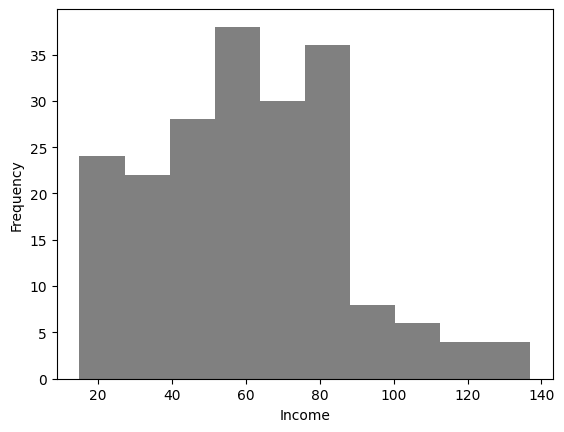

In [12]:
mall.Income.plot.hist(color='gray')
plt.xlabel('Income')
plt.show()

### Отдельная колонка для значения заработка

In [14]:
mall['Cluster'] = np.where(mall.Income >= 90, 'High earners', \
                            np.where(mall.Income < 50, \
                            'Low Income', 'Moderate Income'))

In [15]:
mall

,CustomerID,Gender,Age,Income,Spend_score,Cluster
0,1,Male,19,15,39,Low Income
1,2,Male,21,15,81,Low Income
2,3,Female,20,16,6,Low Income
3,4,Female,23,16,77,Low Income
4,5,Female,31,17,40,Low Income
...,...,...,...,...,...,...
195,196,Female,35,120,79,High earners
196,197,Female,45,126,28,High earners
197,198,Male,32,126,74,High earners
198,199,Male,32,137,18,High earners


### Описательная сводка для каждой категории доходов

In [16]:
mall.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
High earners,22.0,108.181818,13.661334,93.0,98.25,103.0,118.25,137.0
Low Income,72.0,33.027778,11.091136,15.0,22.50,33.5,43.00,49.0
Moderate Income,106.0,69.377358,10.651584,50.0,61.00,70.0,78.00,88.0


### Стандартизация данных

In [18]:
scaler = StandardScaler()

In [19]:
cols_to_scale = ['Age', 'Income', 'Spend_score']

In [20]:
data_scaled = mall.copy()

In [21]:
data_scaled[cols_to_scale] = scaler.fit_transform(mall[cols_to_scale])

In [22]:
data_scaled[cols_to_scale].describe()

,Age,Income,Spend_score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


### Расчет расстояния между клиентами

In [24]:
from scipy.spatial.distance import cdist

In [23]:
sel_cols = ['Income', 'Spend_score']
cust3 = data_scaled[sel_cols].head(3)
cust3

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


Расстояние:
* между 1-м и 2-м - 1.63
* между 1-м и 3-м - 1.28
* между 2-и и 3-м - 2.91

In [25]:
cdist(cust3, cust3, metric='euclidean')

array([[0.        , 1.63050555, 1.28167999],
       [1.63050555, 0.        , 2.91186723],
       [1.28167999, 2.91186723, 0.        ]])

Проверка

In [26]:
np.sqrt((-1.739+1.739)**2 + (-0.4348-1.1957)**2)

1.6305

### k-means

In [30]:
from sklearn.cluster import KMeans

In [27]:
cluster_cols = ['Income', 'Spend_score']
data_scaled[cluster_cols].head(3)

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


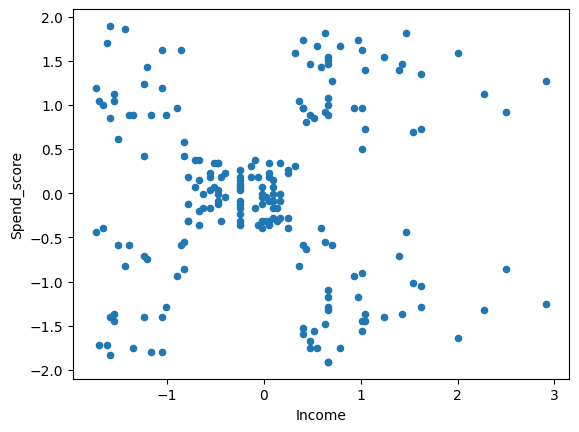

In [29]:
data_scaled.plot.scatter(x='Income', y='Spend_score')
plt.show()

In [31]:
model = KMeans(n_clusters=5, random_state=42)

Определение кластера для каждой модели

In [40]:
model.fit(data_scaled[cluster_cols])

data_scaled['Cluster'] = model.predict(data_scaled[cluster_cols])

In [41]:
data_scaled.head(3)

,CustomerID,Gender,Age,Income,Spend_score,Cluster
0,1,Male,-1.424569,-1.738999,-0.434801,2
1,2,Male,-1.281035,-1.738999,1.195704,3
2,3,Female,-1.352802,-1.700830,-1.715913,2


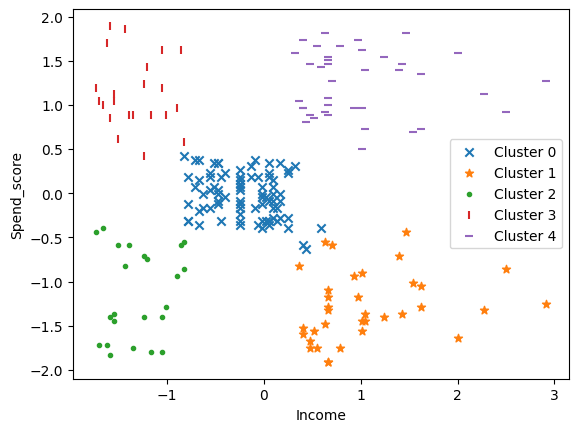

In [44]:
markers = ['x', '*', '.','|','_']

for clust in range(5):
    temp = data_scaled[data_scaled.Cluster == clust]
    plt.scatter(temp.Income, temp.Spend_score,
                marker=markers[clust],
                label="Cluster "+str(clust))
plt.xlabel('Income')
plt.ylabel('Spend_score')
plt.legend()
plt.show()
